# ResNet-Competition

__Author:<br>
Lucas Grönlund [Lucasgronlund@gmail.com](mailto:Lucasgronlund@gmail.com)__

In [1]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np

# load (downloaded if needed) the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Using TensorFlow backend.


In [2]:
from keras.models import Model
from keras.callbacks import EarlyStopping
ES = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

In [3]:
## Imports

from keras.utils import to_categorical
from keras.layers import Input, Dense, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.regularizers import l2
from keras.models import Model
from keras.models import Sequential
from keras.layers.merge import add

In [4]:
## Functions

def building_Block(inputs, layerSizes, layers = 2, schema = "paper",
                   residualNet = True, regParam = 0.01, dropout = False, dropoutRate = 0.01):
    '''Creates a 'block' as described in the paper.
    layers    : The amount of layers i a block
    layerSizes: The size of a layer.
    '''
    
    if(isinstance(layerSizes, int)):
        # Convert to list if currently int
        layerSizes = [layerSizes]*layers
        
    f = x;

    for i in np.arange(layers):
        # Build a block
        
        if(schema == "paper"):
            f = Dense(layerSizes[i], activation='relu')(f)
            f = BatchNormalization()(f)
            f = Activation(activation="relu")(f)
            
        if(schema == "mlp"):
            f = Dense(layerSizes[i], activation="relu")(f)
            
        else:
            if(i == 0):
                f = Dense(layerSizes[i], activation="relu",
                          kernel_regularizer=l2(regParam), use_bias = False)(f)
                if(dropout): f = Dropout(dropoutRate)(f)

            else:
                f = Dense(layerSizes[i], activation="relu",
                          kernel_regularizer=l2(regParam))(f)
                if(dropout): f = Dropout(dropoutRate)(f)

    
    # Add if resNet structure
    if(residualNet): f = add([f,x]); 
        
    return f;

In [5]:
## Pre-processing

# One-Hot
y_train_OH = to_categorical(y_train)
y_test_OH  = to_categorical(y_test)

# normalize and center
X_train_new = X_train/255
X_test_new  = X_test/255

X_train_new -= X_train_new.mean(axis=0)
X_test_new -= X_test_new.mean(axis=0)

In [6]:
## Model params

numberOfBlocks = 1
layerSize = 12
numberOfLayers = 3
regParam = 0
dropout = False
dropoutRate = 0.1

In [13]:
## Building and training the model

# Define input shape
inputs = Input((28, 28))

# Flatten the input to 28*28
x = Flatten()(inputs)

# Dense layer with relu activation
x = Dense(layerSize, activation='relu', kernel_regularizer=l2(regParam))(x)

if(dropout): x = Dropout(dropoutRate)(x)

# Build the blocks
for i in np.arange(numberOfBlocks):
    x = building_Block(inputs=x, layerSizes = layerSize,
                       schema="other", layers=numberOfLayers,
                       regParam=regParam, dropout=dropout, dropoutRate=dropoutRate)

# Output layer with sigmoid activation
x = Dense(units=10, activation='sigmoid', kernel_regularizer=l2(regParam), use_bias=False)(x)

# Create model
model = Model(inputs, x)

# Compilte and fit model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
info = model.fit(X_train_new, y_train_OH,
                 validation_data=(X_test_new, y_test_OH),
                 callbacks=[ES], epochs=100, batch_size=100, verbose=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
 - 2s - loss: 0.6666 - acc: 0.8151 - val_loss: 0.2667 - val_acc: 0.9212
Epoch 2/100
 - 1s - loss: 0.2524 - acc: 0.9264 - val_loss: 0.2199 - val_acc: 0.9342
Epoch 3/100
 - 1s - loss: 0.2144 - acc: 0.9372 - val_loss: 0.1992 - val_acc: 0.9394
Epoch 4/100
 - 1s - loss: 0.1943 - acc: 0.9423 - val_loss: 0.1879 - val_acc: 0.9445
Epoch 5/100
 - 1s - loss: 0.1810 - acc: 0.9459 - val_loss: 0.1798 - val_acc: 0.9454
Epoch 6/100
 - 1s - loss: 0.1706 - acc: 0.9489 - val_loss: 0.1764 - val_acc: 0.9478
Epoch 7/100
 - 1s - loss: 0.1628 - acc: 0.9507 - val_loss: 0.1740 - val_acc: 0.9486
Epoch 8/100
 - 1s - loss: 0.1562 - acc: 0.9534 - val_loss: 0.1721 - val_acc: 0.9504
Epoch 9/100
 - 1s - loss: 0.1509 - acc: 0.9547 - val_loss: 0.1694 - val_acc: 0.9506
Epoch 10/100
 - 1s - loss: 0.1462 - acc: 0.9560 - val_loss: 0.1666 - val_acc: 0.9523
Epoch 11/100
 - 1s - loss: 0.1411 - acc: 0.9571 - val_loss: 0.1673 - val_acc: 0.9508
Epoch 12/100
 - 1s - los



Number of trainable parameters: 9996

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 28, 28)       0                                            
__________________________________________________________________________________________________
flatten_7 (Flatten)             (None, 784)          0           input_7[0][0]                    
__________________________________________________________________________________________________
dense_31 (Dense)                (None, 12)           9420        flatten_7[0][0]                  
__________________________________________________________________________________________________
dense_32 (Dense)                (None, 12)           144         dense_31[0][0]                   
_____________________________________________________________________

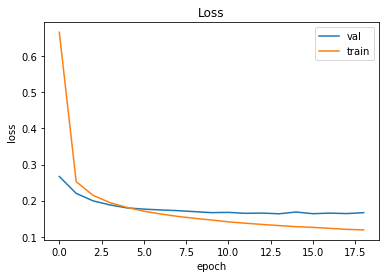

In [17]:
## Summary and plots

print("\n\nNumber of trainable parameters: " + repr(model.count_params()))
print("")
model.summary()

plt.plot(info.epoch, info.history['val_loss'], label="val")
plt.xlabel('epoch'), plt.ylabel('loss')
plt.plot(info.epoch, info.history['loss'], label="train")
plt.xlabel('epoch'), plt.ylabel('loss'), plt.title('Loss'), plt.legend()
plt.show()